<a href="https://colab.research.google.com/github/mjgonzalezGUD/TFM_denoising_transformers/blob/main/CARE_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised CARE Training
Here we will train a plain N2V network on single noisy images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/unet')
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/pn2v')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from model import UNet

import utils
import histNoiseModel
import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data 

####LoadDataConvallaria

(100, 1024, 1024, 1) (100, 1024, 1024, 1)
(100, 1024, 1024, 2) (100, 1024, 1024, 1)


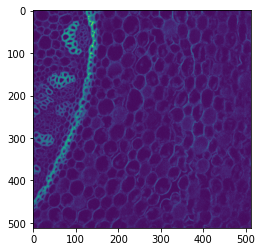

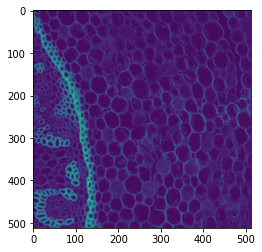

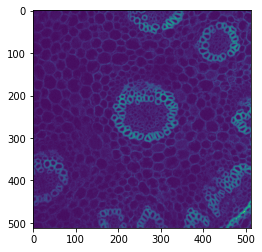

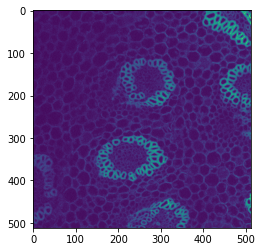

(300, 512, 512, 2)


In [ ]:

path='/content/drive/MyDrive/project_folder/pn2v-master/Convallaria_diaphragm/'

# Load the training data
data=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')
dataGT = np.mean(data,axis=0)[np.newaxis,...,np.newaxis]

data=data[...,np.newaxis]

dataGT = np.repeat(dataGT, 100, axis=0)
print(data.shape,dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
print(data.shape,dataGT.shape)


plt.imshow(data[0,512:,512:,0])
plt.show()
plt.imshow(data[0,:512,512:,0])
plt.show()
plt.imshow(data[0,512:,:512,0])
plt.show()
plt.imshow(data[0,:512,:512,0])
plt.show()

# We now crop away the data that has is to be used for testing
data=np.concatenate( (data[:,512:,512:,:], data[:,:512,512:,:], data[:,512:,:512,:])  )
print (data.shape)

####LoadData CBDS68

(3168, 180, 180, 1) (3168, 180, 180, 1)
(3168, 180, 180, 2) (3168, 180, 180, 1)


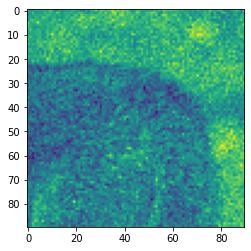

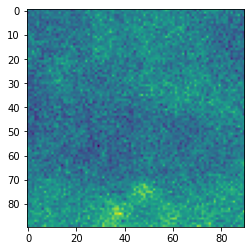

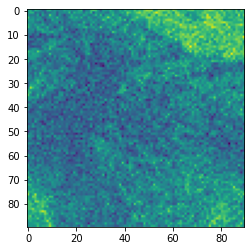

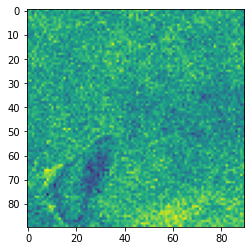

(9504, 90, 90, 2)


In [ ]:
path = '/content/drive/MyDrive/project_folder/pn2v-master/data/BSD68_reproducibility_data/train/'
path_val = '/content/drive/MyDrive/project_folder/pn2v-master/data/BSD68_reproducibility_data/val/'


# Load the training data
data=np.load(path+'DCNN400_train_gaussian25.npy').astype(np.float32)
dataGT = np.mean(data,axis=0)[np.newaxis,...,np.newaxis]

data=data[...,np.newaxis]

dataGT = np.repeat(dataGT, 3168, axis=0)
print(data.shape,dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
print(data.shape,dataGT.shape)


plt.imshow(data[0,90:,90:,0])
plt.show()
plt.imshow(data[0,:90,90:,0])
plt.show()
plt.imshow(data[0,90:,:90,0])
plt.show()
plt.imshow(data[0,:90,:90,0])
plt.show()

# We now crop away the data that has is to be used for testing
data=np.concatenate( (data[:,90:,90:,:], data[:,:90,90:,:], data[:,90:,:90,:])  )
print (data.shape)

## Create the Network and Train it
This can take a while.

###BSD68

In [ ]:
# The N2V network requires only a single output unit per pixel
net = UNet(1 ,depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
print(my_train_data.shape, my_val_data.shape)
# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix='conv_CARE', directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=50, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True,patchSize = 64)


                                          

/content/drive/MyDrive/project_folder/pn2v-master/unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/content/drive/MyDrive/project_folder/pn2v-master/unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


(9499, 90, 90, 2) (5, 90, 90, 2)
Epoch 0 finished      
avg. loss: 0.028813971020281316+-(2SEM)0.008020241111482038      
Epoch 1 finished      
avg. loss: 0.016735629132017493+-(2SEM)0.004861643580699359      
Epoch 2 finished      
avg. loss: 0.006206329958513379+-(2SEM)0.0009424734404096128      
Epoch 3 finished      
avg. loss: 0.004385213408386335+-(2SEM)0.0006849481814136376      
Epoch 4 finished      
avg. loss: 0.002692491374909878+-(2SEM)0.0006064029055877149      
Epoch 5 finished      
avg. loss: 0.002088407229166478+-(2SEM)0.00032352744376578106      
Epoch 6 finished      
avg. loss: 0.0015936477546347305+-(2SEM)0.00030830305628125424      
Epoch 7 finished      
avg. loss: 0.001284059919998981+-(2SEM)0.00026036788608147285      
Epoch 8 finished      
avg. loss: 0.0009706066397484392+-(2SEM)0.0002516480683685051      
Epoch 9 finished      
avg. loss: 0.0005644216013024561+-(2SEM)7.075303087798605e-05      
Epoch 10 finished      
avg. loss: 0.00041559179953765124+-(2SE

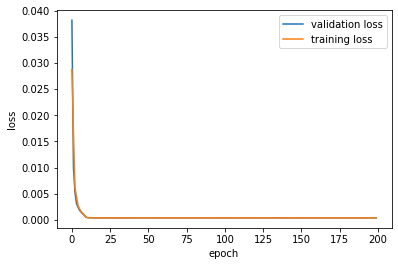

In [ ]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()

###CONVALLARIA

In [ ]:
# The N2V network requires only a single output unit per pixel
net = UNet(2, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

print (my_train_data.shape, my_val_data.shape)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix='conv_CARE', directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=50, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

/content/drive/MyDrive/project_folder/pn2v-master/unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/content/drive/MyDrive/project_folder/pn2v-master/unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


(295, 512, 512, 2) (5, 512, 512, 2)
Epoch 0 finished      
avg. loss: 0.14475994631648065+-(2SEM)0.029707304576946612      
Epoch 1 finished      
avg. loss: 0.30208458602428434+-(2SEM)0.1459664093850995      
Epoch 2 finished      
avg. loss: 0.1282181240618229+-(2SEM)0.05535935510497798      
Epoch 3 finished      
avg. loss: 0.11978860087692737+-(2SEM)0.020190647350597446      
Epoch 4 finished      
avg. loss: 0.08002536091953516+-(2SEM)0.018713889779020047      
Epoch 5 finished      
avg. loss: 0.056982601154595615+-(2SEM)0.03024946362505117      
Epoch 6 finished      
avg. loss: 0.04687559502199292+-(2SEM)0.015892752887839777      
Epoch 7 finished      
avg. loss: 0.030615783110260964+-(2SEM)0.007854973264439574      
Epoch 8 finished      
avg. loss: 0.0513644278049469+-(2SEM)0.01825856119705202      
Epoch 9 finished      
avg. loss: 0.04989630873315036+-(2SEM)0.01668742253412863      
Epoch 10 finished      
avg. loss: 0.043142409063875675+-(2SEM)0.016382559158993348      


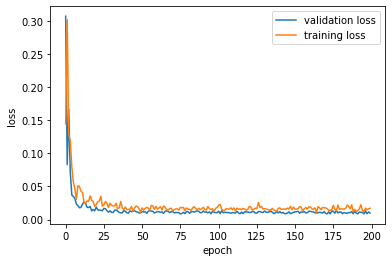

In [ ]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()